# 0. Introduction

Hi, and welcome to the exercise of gap-filling. Before you start with this exercise, it is best you first completed following exercises:
1. Introduction_01
2. Quality_control_exercise_02

This exercise covers the most important functions about gaps and gap-filling, and consists of two main parts.

**Part 1**

In the first part you will work with a demo data set, which consists of a number of gaps. In this first part you will find the answers to the following questions:
- How do I get more information about the gaps (e.g. number of gaps, length of the gaps, location in the data set)?
- How do I perform the different gap-filling techniques?
- Which gap-filling technique is best?

For this part of the exercise a lot of code is already present for you. Read through the text and examples and try to perform small changes to the code where asked. Try to understand what the functions do and interpret the results. At the end of this part you should understand the difference between the gap-filling techniques and how to perform them.

**Part 2**

In the second part of the exercise you will apply the previous introduced functions to your own data set. The goal is to get a complete version of your data set, by applying the gap-filling techniques to your data set.

For this part the code from part 1 will be copy pasted, but it is your job to adjust the code so it works for your own data set.

**Get started**

To get started, first make sure you work in your own copy of this exercise, which you stored in your own Drive folder "*FAIRNESS_summerschool_23*". Next, run the two code cels below to install and import all necessary packages.

In [ ]:
# Install the MetObs-toolkit package
!pip3 install git+https://github.com/vergauwenthomas/MetObs_toolkit
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [ ]:
# Import all the necessary packages for this exercise
import sys, os
import pandas as pd
import datetime as dt
import metobs_toolkit

Don't forget that you can find extra information about the package and all the functions at following website: https://vergauwenthomas.github.io/MetObs_toolkit/

# Part 1: gap-filling of a demo data set

## 1.0 Missing observations versus gap

Before you start to explore the gaps in a demo data set, first an explanation is needed on the definition of a *gap* and the difference with a *missing observation*.

First of all an observation can be missing because of two reasons:
1. The timestamp is not present in the data set.
2. There is no value known, and it is represented with a NaN-value.

Every time one of these two occurs, it is labeled as a *missing observation*. A consecutive series of missing observations are labeld as a *gap*. The minimum number of missing observations needed to define a gap is stored in the settings with the parameter "gapsize_n". The default value of this parameter is 40. Note that a gap is not defined based on the length of the time period which is missing, but only on the number of missing observations. When performing one of the gap-filling techniques, only the gaps are filled, while the missing observations not defined as a gap are left blank. The missing observations can be filled, but this has to be performed separately (see later in this exercise).

As an example, in the figures you can see two kinds of missing observations:
1. On the left: missing timestamps. In total 48 timestamps are missing, since the time resolution of the data set is 5 minutes. These series of missing observations are therefore listed under *gap*.
2. On the right: missing values for the temperature ('Temperatuur' in Dutch). In total 5 observations are missing, and therefore this is not considered a gap. These 5 missing values will be listed under *missing observation*.

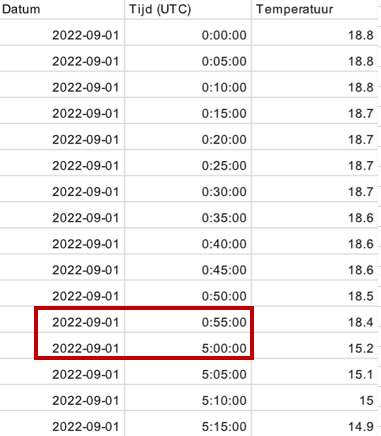        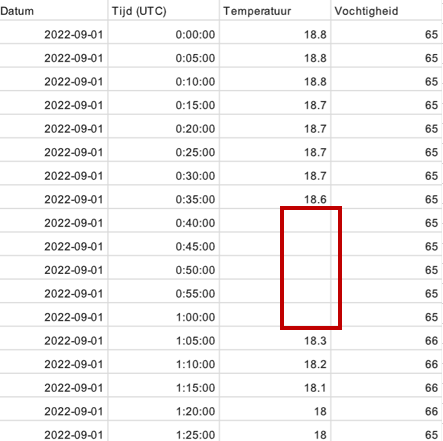


## 1.1 Read in the data

For this part of the exercise a copy of the data set from the introduction exercise is used. In this copy, some timestamps and values are removed. In this way an incomplete data set is created.

The data set, named "*demo_datafile_incomplete.csv*", is stored in the public Drive folder "*FAIRNESS_summerschool_23_master*". If you followed the instructions correctly at the beginning of the first exercise session, this file is also stored in your personal Drive folder "*FAIRNESS_summerschool_23*".

**Attention!**

Make sure the data set is stored in the same way as in the public Drive folder. This means:
- The data set is stored in a folder named "*exercises_data*"
- The data set is named "*demo_datafile_incomplete.csv*" (it is possible the name contains 'Copy of' when you made a copy: change the name back to its original name)


To be able to acces the data file, you need access to your personal Google Drive. Run the code cel below, select your Google account and give the permission.

In [ ]:
# Make connection with your personal Google Drive folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

To read in the data set, you need to specify the path to your Google Drive folder which contains the data set. Run the code cel below to specify the path to the data file.

In [ ]:
# Specify the path to the folder with the data file

# Specify the path to your Drive folder
BASE_DIR = '/content/drive/MyDrive/FAIRNESS_summerschool_23/'
print('BASE_DIR: ',BASE_DIR)

# Construct the path, by adding the name of the folder and file
data_path = os.path.join(BASE_DIR, 'exercises_data', 'demo_datafile_incomplete.csv')

Read the data set in by running the code cel below. As you learned during the introduction exercise, the data set is read in by performing the following steps:
1. Make an empty Dataset object.
2. Change the settings, so the path to the data files is known.
3. EXTRA: Change in the settings the number of missing observations needed to define a gap.
4. Import the data set.

The first five rows of the data set are printed.

During the exercise on quality control, you learned that an initial quality control is performed when the data set is read in. This initial quality control will determine the time resolution for each station, and based on this time resolution missing observations are determined. The assumed time resolution can be checked by printing the metadf dataframe by adding `.metadf` after the data set name. The assumed time resolution is stored in the column "*assumed_import_frequency*".

The number of missing observations to define a gap is set to 12. What does this mean in term of time? What is the minimum length of a gap expressed in time?

*Hint: use the time resolution of the data set.*

In [ ]:
# READ IN INCOMPLETE DATA SET

# Make an empty data set
demo_incomplete = metobs_toolkit.Dataset()

# Update settings with path to data files
demo_incomplete.update_settings(
                        input_data_file= data_path,
                        input_metadata_file = metobs_toolkit.demo_metadatafile,
                        data_template_file = metobs_toolkit.demo_template,
                        metadata_template_file = metobs_toolkit.demo_template
                        )

# Update the gap definition if required
demo_incomplete.update_qc_settings(
                                  gapsize_in_records = 12,
                                 )

# Import the data set
demo_incomplete.import_data_from_file()

# Print the first five lines
print("First five lines of data set:")
print(demo_incomplete.df.head(5))

# Print the column 'assumed_import_frequency' of the metadf dataframe, to look at the assumed time resolution
print("Metadf dataframe:")
print(demo_incomplete.metadf.assumed_import_frequency)

The initial quality control will remark both kinds of missing observations, but they are now stored in a different way:
1. The missing timestamps are already labeled under *missing observation* or *gap*, based on the number of consecutive missing timestamps.
2. A missing value (NaN-value) is labeled as invalid observation, which is stored in the outliersdf dataframe. These missing values are not automatically categorised under *missing observation* or *gap*. To make sure these missing values are also labeled as *missing observation* or *gap*, you need to update the missing observations and gaps.

In the code cel below, the outliersdf is printed. You can see some NaN-values are present. By adding `.update_gaps_and_missing_from_outliers()` after the data set, the missing observations and gaps are updated with these outliers.

In [ ]:
# Print the outliersdf
print(demo_incomplete.outliersdf)

# Update the missing observations and gaps
demo_incomplete.update_gaps_and_missing_from_outliers(n_gapsize=12)

## 1.2 Get information about the gaps

Before performing any gap-filling techniques, it can be usefull to first analyse the gaps. Run the code cels below to get information on the gaps of the incomplete data set.

The first code cel retrieves general information about all the gaps of the incomplete data set. You can get information about the start, end and length of the gaps in the form of a list by adding `.get_gaps_df()` after the name of the Dataset. You can also get more detailed information about the gaps by adding `.get_gaps_info()` after the name of the Dataset.

The second code cel retrieves information about a specific gap of the data set. A specific gap is selected by adding `.gaps[]` after the name of the dataset with the number of the gap between [  ], but note that you have to start counting from 0! Information on this specific gap can be retrieved in two ways:
1. adding `.to_df()`, to get the information in the form of a list.
2. adding `.get_info()`, to get general information about the gap, including information about the gap-filling (if it is already performed).

You can also get information about the missing observations, as shown by the third code cel. This is done by adding `.get_missing_obs_info()` after the name of the Dataset.

Try to anwser following questions:
- How many gaps are present?
- Which station has the most gaps?
- How long are the gaps?

In [ ]:
# Get general information about all the gaps of the data set
print("Information about all gaps in the data set:")
print(demo_incomplete.get_gaps_df())
print(demo_incomplete.get_gaps_info())

In [ ]:
# Get detailed information about one of the gaps of the data set (! Start counting from 0 to get the first gap !)
print("Information on the first gap:")
print(demo_incomplete.gaps[0].to_df())
print(demo_incomplete.gaps[0].get_info())

In [ ]:
# Get info about missing observations
print("Information about the missing observations")
print(demo_incomplete.get_missing_obs_info())

***Extra***

It is also possible to select the gaps for one single station. Choose one station (they al start with 'vlinder'), substitute its name in *station_name* in the code cel below and run it to obtain the gaps of this specific station.

In [ ]:
# Get detailed information of the gaps of one station
your_chosen_station = demo_incomplete.get_station('station_name')
print(your_chosen_station.get_gaps_df())

The gaps can be visualised by making a timeplot of the incomplete data set. In the code cel below a timeplot is made of the temperature for a certain time period and for one of the stations. Run the code cel below and try to understand what the different lines of code stand for.



In [ ]:
# Make timeplot of data set

# Select a station and time period
stationname = "vlinder28"
begin_plot = dt.datetime.strptime("2022-09-04 20:00:00", '%Y-%m-%d %H:%M:%S')
end_plot = dt.datetime.strptime("2022-09-07 15:00:00", '%Y-%m-%d %H:%M:%S')

# Make timeplot
demo_incomplete.make_plot(
                          stationnames=[stationname],
                          obstype='temp',
                          colorby='name',
                          starttime=begin_plot,
                          endtime=end_plot,
                          legend=False,
                          show_outliers=False
                          )


Now it is your turn to visualise one of the gaps. Choose one of the gaps from te previous list of gaps you retreived and adjust the code in the cel below to plot this gap. Make sure you make the plot 'wider' than the gap itself, by choosing the beginning and end of the plot before and after the beginning and end of the gap (e.g. 1 day extra on each side of the gap).

In [ ]:
# Make timeplot of data set (for your chosen gap!)

# Select a station and time period
stationname = "vlinder28"   # Change this for your chosen gap!
begin_plot = dt.datetime.strptime("2022-09-04 20:00:00", '%Y-%m-%d %H:%M:%S') # Change this for your chosen gap!
end_plot = dt.datetime.strptime("2022-09-07 15:00:00", '%Y-%m-%d %H:%M:%S') # Change this for your chosen gap!

# Make timeplot
demo_incomplete.make_plot(
                          stationnames=[stationname],
                          obstype='temp',
                          colorby='name',
                          starttime=begin_plot,
                          endtime=end_plot,
                          legend=False,
                          show_outliers=False
                          )


## 1.3 Prepare the data set for the gap-filling

Before we start with the gap-filling, we prepare the data set by only selecting the data we are interested in. These steps are not necessary, but they help minimise the computing time of the gap-filling functions.

Following alterations/selections can be made:
1. Change the time resolution, if the original time resolution is not the desired one.
2. Select the station, if the gap-filling only needs to be performed for a specific station.

In the code cel below, the functions to perform these changes are already given for a random time resolution and a random station. Change the code below so the result (named *Station*):
1. Has a time resolution of one hour
2. Only consists of the data of station *vlinder04*

After you made the changes, run the code cel and check if the result matches these two requirements.


In [ ]:
# Change the time resolution
demo_incomplete.coarsen_time_resolution(freq = "30T")

# Select one station
Station = demo_incomplete.get_station('name_station')

# Print the first 5 lines of the result
print(Station.df.head(5))

Remember that besides the gaps, there are also missing observations which are not labeled as gap. These missing observations can be filled through linear interpolation. The selected station *vlinder04* does not have any missing observations to fill, but if this was the case, the code cel below would fill all missing observations.

In [ ]:
# Fill the missing observations through linear interpolation
# (you don't have to run this code cel, since vlinder04 does not have any missing obsevations)
Station.fill_missing_obs_linear()

Now you are ready to start filling some gaps! In the following sections different gap-filling techniques are explained. The exercise will only fill the temperature data, but by changing the parameter *obstype* you can perform the gap-filling for other observational types. We only fill the gaps in the prepped data set *Station*, only containing hourly data of *vlinder04*. The gap-filling functions could also be performed on the whole data set, using the exact same functions.

## 1.4 Perform linear interpolation

The first technique to fill gaps, is by performing a linear interpolation between the data point before and after the gap. Run the code cel below to perform linear interpolation on the data of *vlinder04* and to visualise the result for one of the gaps.

In [ ]:
# Perform linear interpolation
Station.fill_gaps_linear(obstype='temp')

# Select a station and time period
stationname = "vlinder04"
begin_plot = dt.datetime.strptime("2022-09-03 00:00:00", '%Y-%m-%d %H:%M:%S')
end_plot = dt.datetime.strptime("2022-09-03 23:00:00", '%Y-%m-%d %H:%M:%S')

# Make timeplot
Station.make_plot(
                  stationnames=[stationname],
                  obstype='temp',
                  colorby='label',
                  starttime=begin_plot,
                  endtime=end_plot,
                  legend=False,
                  show_outliers=False
                  )

Now it is up to you to look at the result of the gap-filling for other gaps.. Choose another gap of *vlinder04* (use the list of gaps you retrieved before) and adjust the code below to visualise the result of the gap-filling. Do this for both a very small gap (<5 hours) and a very large gap (>24 hours).

Answer the following questions:
- Is the linear interpolation technique able to construct the daily variation in temperature?
- For which gaps does the linear interpolation technique work best?
- Do you expect similar performance for other observation types (e.g. wind speed, evaporation, humidity, ...)? (If you reached the end of the gap-filling exercise and you have time left, you can come back to this part and actually perform the gap-filling for other observation types to test your hypotheses.)


In [ ]:
# Select a station and time period
stationname = "vlinder04"
begin_plot = dt.datetime.strptime("2022-09-03 00:00:00", '%Y-%m-%d %H:%M:%S') # Change this for your chosen gap!
end_plot = dt.datetime.strptime("2022-09-03 23:00:00", '%Y-%m-%d %H:%M:%S') # Change this for you chosen gap!

# Make timeplot
Station.make_plot(
                  stationnames=[stationname],
                  obstype='temp',
                  colorby='label',
                  starttime=begin_plot,
                  endtime=end_plot,
                  legend=False,
                  show_outliers=False
                  )

## 1.5 Fill gaps with ERA5

Another gap-filling technique uses model data, like ERA5, and replaces the missing observations of the gap with the corresponding observations of ERA5. More information about ERA5 can be found on [this site](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview).


Before we can fill the gaps with ERA5 data, the ERA5 data first needs to be read in. The ERA5 data is obtained through the Google Earth Engine (GEE). The ERA5 data of the GEE can be visualised with an interactive map, which you can access through [this site](https://eur03.safelinks.protection.outlook.com/?url=https%3A%2F%2Fcode.earthengine.google.com%2F%3FscriptPath%3DExamples%253ADatasets%252FECMWF%252FECMWF_ERA5_LAND_HOURLY&data=05%7C01%7Camber.jacobs%40ugent.be%7Ca870eedc689a4de2b3d208db7252ba2e%7Cd7811cdeecef496c8f91a1786241b99c%7C1%7C0%7C638229471857464520%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000%7C%7C%7C&sdata=cZqdRVwqBrpvgoGSQpF%2BnxH17xVOLS2i8z08KXU2P6k%3D&reserved=0). By clicking on the 'Run' button in the middle, the map is loaded and you can click on any location on the map to get the ERA5 data information. One remark: it is possible this site does not yet work for you. In this case, you first have to complete the next step of this exercise (creating your GEE authentication).

In order to get access to the ERA5 data, you need to setup your personal google earth engine authentication. Folow the steps described on this page, in order to create this authentication: https://vergauwenthomas.github.io/MetObs_toolkit/gee_authentication.html

Test your acces to the GEE, by running the code cel below, which will acces the GEE and read in the ERA5 data needed to fill gaps. After you run the code, a link will appear. Follow the next steps:
1. A link will appear, click on it
2. (first time only) hit 'CHOOSE PROJECT' and select your existing cloud project
3. do NOT click the read_only scopes!
4. hit 'GENERATE TOKEN' --> select your google account --> hit 'CONTINUE'
5. Select both boxes and hit 'Continue'
6. An authorization code is generated, copy it
7. In your notebook, paste the code in propted-box and hit Enter

If everything went right, the text 'Successfully saved authorization token.' and the first five lines of the ERA5 data should be printed.



In [ ]:
# Get the ERA5 data
era_model = demo_incomplete.get_modeldata(
                    modelname='ERA5_hourly',  # Name of the model data to get from GEE
                    stations='vlinder04',     # If only for one station: specify its name, if None the data is downloaded for all stations
                    startdt=None,             # None means the starttime of the observations is taken
                    enddt=None)               # None means the endtime of the observations is taken

# Print the first five lines
print(era_model.df.head())

To be able to work with the model data, it needs to be stored as a Modeldata object, which is similar to the Dataset object you make when you want to read in your observational data set. The above function `get_modeldata()` automatically makes a Modeldata object for the ERA5 data, except for the case when the ERA5 data is very large.

**Note**:

If the needed ERA5 data is very large, a message can appear on the screen saying that the modeldata is written to a file in google drive (folder: era5_timeseries/era5_data).

To work further with this model data, we need to make a modeldata object and read the model data in. This happens in a similar way as reading in the observational data sets.
1. Make an empty Modeldata object
2. Read in the ERA5 data from where it is stored

The code cel below contains the code to make the Modeldata object. Since for this example the ERA5 data was small enough, you do not need to run this code.

In [ ]:
# Do NOT run this code
# This code serves as an example for the case the ERA5 data is large, in which you received a message when running the previous code cel.

# Make an empty Modeldata object
era_model = metobs_toolkit.Modeldata('ERA5_hourly')

# Read in the ERA5 data
era_model.set_model_from_csv(csvpath='PATH_TO_ERA5_DATA')

Now the ERA5 data is ready to use, the gap-filling technique can be performed.

Since the ERA5 data contains a bias, it is best to first debias the ERA5 data before filling the data set with it. The function `fill_gaps_era5()` uses the datapoints before and after the gap to estimate the bias of ERA5. This knowledge is then used to correct the ERA5 data before filling the gaps with it.

Run the code cel below to perform the gap-filling with ERA5 and to visualise one of the filled gaps.

**Note**:

The parameter `overwrite_fill` is set to `True` because we want to overwrite the previous gap-filling results (obtained through linear interpolation). If this parameter is not set to True, a warning will appear saying that the previous gap-filling will not be overwritten.


In [ ]:
# Fill gaps by filling with the debiased ERA5 data
Station.fill_gaps_era5(modeldata=era_model,   # The name of the Modeldata object
                       method='debias',       # Before filling with ERA5, debias first
                       obstype='temp',        # Perform gap-filling on temperature
                       overwrite_fill=True)   # Overwrite the previous results

# Select a station and time period
stationname = "vlinder04"
begin_plot = dt.datetime.strptime("2022-09-03 00:00:00", '%Y-%m-%d %H:%M:%S')
end_plot = dt.datetime.strptime("2022-09-03 23:00:00", '%Y-%m-%d %H:%M:%S')

# Make timeplot
Station.make_plot(
                  stationnames=[stationname],
                  obstype='temp',
                  colorby='label',
                  starttime=begin_plot,
                  endtime=end_plot,
                  legend=False,
                  show_outliers=False
                  )

Again, look at the result of the gap-filling for other gaps. Choose another gap of *vlinder04* and adjust the code below to visualise the result of the gap-filling. Do this for both a very small gap (<5 hours) and a very large gap (>24 hours).

Answer the following questions:
- Is the the ERA5 gap-filling technique able to construct the daily variation in temperature?
- For which gaps does the ERA5 gap-filling technique work best?
- Do you expect similar performance for other observation types (e.g. wind speed, evaporation, humidity, ...)? (If you reached the end of the gap-filling exercise and you have time left, you can come back to this part and actually perform the gap-filling for other observation types to test your hypotheses.)

In [ ]:
# Select a station and time period
stationname = "vlinder04"
begin_plot = dt.datetime.strptime("2022-09-03 00:00:00", '%Y-%m-%d %H:%M:%S') # Change this for your chosen gap!
end_plot = dt.datetime.strptime("2022-09-03 23:00:00", '%Y-%m-%d %H:%M:%S') # Change this for you chosen gap!

# Make timeplot
Station.make_plot(
                  stationnames=[stationname],
                  obstype='temp',
                  colorby='label',
                  starttime=begin_plot,
                  endtime=end_plot,
                  legend=False,
                  show_outliers=False
                  )

## 1.6 Fill gaps with a hybrid method

Now that you filled the gaps with both the linear interpolation technique and the ERA5 technique, you have an idea on the performance of these techniques. Use your insights to answer the following questions:
- Which gaps would you fill with linear interpolation?
- Which gaps would you fill with ERA5?

Out of your previous examination of the techniques, you should conclude that the linear interpolation works best for small gaps, while for larger gaps the ERA5 technique is preferred. This hybrid approach, that fills the gap according to the length of the gap, can be performed by using the function `fill_gaps_automatic()`. Run the code cel below to perform the hybrid gap-filling technique.

**Note**:

Again the parameter `overwrite_fill` is set to `True` because we want to overwrite the previous gap-filling results (obtained through debiasing ERA5).

In [ ]:
# Fill gaps with the hybrid method
Station.fill_gaps_automatic(modeldata=era_model,
                            obstype="temp",
                            max_interpolate_duration_str='6H',
                            overwrite_fill=True)

# Select a station and time period
stationname = "vlinder04"
begin_plot = dt.datetime.strptime("2022-09-03 00:00:00", '%Y-%m-%d %H:%M:%S')
end_plot = dt.datetime.strptime("2022-09-03 23:00:00", '%Y-%m-%d %H:%M:%S')

# Make timeplot
Station.make_plot(
                  stationnames=[stationname],
                  obstype='temp',
                  colorby='label',
                  starttime=begin_plot,
                  endtime=end_plot,
                  legend=False,
                  show_outliers=False
                  )

One of the input parameters of this function is *max_interpolate_duration_str*. This parameter defines when to switch between the techniques. Choose one of the gaps of *vlinder04*, and change the code below so it visualises the gap-filling of this gap. Run the code cel below two times:
1. One time with *max_interpolate_duration_str* smaller than the gap length of your chosen gap.
2. One time with *max_interpolate_duration_str* larger than the gap length of your chosen gap.

Do you see the difference in the used gap-filling technique?

What happens if the gap is the exact same length as the value of *max_interpolate_duration_str*? Try to find out which technique is used in this case. Cross reference your answer with the documentation on the function `fill_gaps_automatic()` (go to https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.fill_gaps_automatic).

In [ ]:
# Fill gaps with the hybrid method
Station.fill_gaps_automatic(modeldata=era_model,
                            obstype="temp",
                            max_interpolate_duration_str='6H', # Change this for your choice of parameter!
                            overwrite_fill=True)

# Select a station and time period
stationname = "vlinder04"
begin_plot = dt.datetime.strptime("2022-09-03 00:00:00", '%Y-%m-%d %H:%M:%S') # Change this for your chosen gap!
end_plot = dt.datetime.strptime("2022-09-03 23:00:00", '%Y-%m-%d %H:%M:%S') # Change this for you chosen gap!

# Make timeplot
Station.make_plot(
                  stationnames=[stationname],
                  obstype='temp',
                  colorby='label',
                  starttime=begin_plot,
                  endtime=end_plot,
                  legend=False,
                  show_outliers=False
                  )

If you want information about the gap-filling technique used on a certain gap, you don't necessarily have to make a plot. You can also get this information by asking the general information of a gap, using the `get_info()` function. If you want this information for every gap, you can do this with a `for` loop, which will go over every gap. Run the code cel below to get information about the performed gap-filling technique, for every gap of *vlinder04*.

In [ ]:
# Get information for every gap of vlinder04
print(Station.get_gaps_info())

# Part 2: gap-filling of your own data set

Now it is time for you to apply the gap-filling functions to your own data set. Try to get an overview of the gaps in your own data set and try to obtain a complete gap-filled data set. The sections below guide you through this journey step by step. Most of the code is copy-pasted from the first part of this exercise, so you need to make changes to make it work for your own data set!

## 2.1 Read in the data

First you need to retrieve your own data set. In the previous exercise you changed the time resolution of your data set and performed an extensive quality control. If everything went correctly, you stored the resulting data set after quality control on your personal Drive folder. You already have connection with your Google Drive. To read in the data set, you only need to run the code cel below.


Make sure you make the following change in the code:
- Specify the path to the folder which contains your quality controlled data set. The path to your "*FAIRNESS_summerschool_23*" folder is already stored in `BASE_DIR`, but you need to specify the name(s) of the folder your quality controlled data set is stored.

The first five lines of your data set are printed. Check these lines to see if you were succesfull.

In [ ]:
# READ IN YOUR QUALITY CONTROLLED DATA SET

# Specify the path to the folder
folder_with_qc_dataset= os.path.join(BASE_DIR, 'NAMEOFFOLDER') # CHANGE THIS

# Make an empty Dataset object
empty_dataset = metobs_toolkit.Dataset()

# Import the quality controlled data set
dataset_incomplete = empty_dataset.import_dataset(folder_path = folder_with_qc_dataset,
                                           filename='qc_controlled_dataset.pkl')

# Print the first 5 lines
print(dataset_incomplete.df.head(5))

After the quality control, the erroneous observations are only 'flagged' but not removed. To remove the erroneous observations and update the missing observations and gaps, run the code cel below.

When running this code cel, you need to make sure you make the right choice for `n_gapsize`. To do this, follow next steps:
1. Choose the minimum length for a gap, expressed in time (for example 3h) (!!! This is a choice you made when reading in your data set !!! Use the same time here !!!)
2. Determine the time resolution of the data set (when you performed the previous quality control exercise correctly, the data set is hourly: 1h)
3. Divide the minimum length of a gap by the time resolution: for example 3h/1h=3. This means 3 consecutive missing observations will be labeld as a gap. This means `n_gapsize=3`.

In [ ]:
# Update the missing observations and gaps
dataset_incomplete.update_gaps_and_missing_from_outliers(n_gapsize=3) # CHANGE THIS FOR YOUR CHOICE OF GAP DEFINITION

## 2.2 Get information about the gaps

Try to obtain information about the gaps and missing observations in your data set.

In [ ]:
# Get general information about all the gaps of the data set
print("Information about all gaps in the data set:")
print(dataset_incomplete.get_gaps_df())
print(dataset_incomplete.get_gaps_info())

# Get detailed information about one of the gaps of the data set (! Start counting from 0 to get the first gap !)
print("Information on the first gap:")
print(dataset_incomplete.gaps[0].to_df())
print(dataset_incomplete.gaps[0].get_info())

# Get info about missing observations
print("Information about the missing observations")
print(dataset_incomplete.get_missing_obs_info())

If you have multiple stations, select one of them and try to get information on the gaps of this station. Don't forget to change the code with the name of your selected station.

In [ ]:
# Get detailed information of the gaps of one station
your_chosen_station = dataset_incomplete.get_station('vlinder04') # CHANGE THIS
print(your_chosen_station.get_gaps_df())

## 2.3 Prepare the data set for the gap-filling

Before performing any gap-filling, determine which data you would like to fill. Make changes to the code below if you want to select a certain station. To check if you were succesfull, look at the first five lines which are printed. If you like to fill your complete data set, and not just a one station, you can simply ignore the code cel below and not run it.

Another step in this prepping stadium is to change the time resolution of the data set. For this exercise we want an hourly data set as result, so we make no changes to the time resolution, since the quality controlled data set was already made hourly in the previous exercise about quality control.

In [ ]:
# Select one station
your_station = dataset_incomplete.get_station('vlinder04') # CHANGE THIS OR DELETE THIS!
print(your_station.df.head(5)) # IF YOU DELETE THE ABOVE LINE, ALSO DELETE THIS LINE

Now, you can first fill the missing observations by performing linear interpolation. **Attention**: you need to make sure you run this for the right data set:
- If you selected a certain station, make sure you run this for the data set '*your_station*'.
- If you want to fill missing observations for you whole data set, make sure you run this for the name of you whole data set *dataset_incomplete*.

In [ ]:
# Fill the missing observations through linear interpolation
your_station.fill_missing_obs_linear()

## 2.4 Perform gap-filling

Before you can perform the gap-filling, you need to get access to the ERA5 data that corresponds to your data set. Make the following change before running the code cel below:
- Change the value of '*stations*': this is the name of your selected station or `None` if you are working with your whole data set

In [ ]:
# Get the ERA5 data
era_model = dataset_incomplete.get_modeldata(
                    modelname='ERA5_hourly',  # Name of the model data to get from GEE
                    stations='vlinder04',     # CHANGE THIS: If only for one station: specify its name,
                                              # if you want to download the data for all stations: put None
                    startdt=None,             # None means the starttime of the observations is taken
                    enddt=None)               # None means the endtime of the observations is taken

# Print the first five lines
print(era_model.df.head())

If the ERA5 data is too large, you should get a notification. If this is the case, also run the code cel below to read in the ERA5 data.

In [ ]:
# DO NOT RUN THIS CODE CEL, except for the case when your ERA5 data set is too large

# Make an empty Modeldata object
era_model = metobs_toolkit.Modeldata('ERA5_hourly')

# Read in the ERA5 data
era_model.set_model_from_csv(csvpath='PATH_TO_ERA5_DATA')

Now it's time to perform the gap-filling. Since the hybrid method uses the best gap-filling technique according to the gaplenght, it is advised to use this method. But don't hold back if you want to try the gap-filling with on of the other two methods!

Run the code cel below to perform the hybrid method, but make sure you first make changes:
- Change the name of the observation type (choose which observation type you want to fill)
- If preferred: change the moment to swith from linear interpolation to debiasing ERA5
- Make sure you run the function for the right data set (did you select one station or do you want to perform gap-filling for your whole data set?)

In [ ]:
# Fill gaps with the hybrid method
your_station.fill_gaps_automatic(modeldata=era_model,
                            obstype="temp",     # CHANGE THIS!
                            max_interpolate_duration_str='6H', # CHANGE THIS, if you want!
                            overwrite_fill=True)

## 2.4 Visualise the filled gaps

If you were succesfull, your (selected) data set is now complete! Make changes in the code cel below to visualise one of your filled gaps, to check if this is indeed the case. Make the following changes:
- Change the name of the station
- Change the begin and end date of the plot
- Change the observation type you want to visualise, which is the one you gap-filled earlier

In [ ]:
# Select a station and time period
stationname = "vlinder04" # CHANGE THIS
begin_plot = dt.datetime.strptime("2022-09-03 00:00:00", '%Y-%m-%d %H:%M:%S') # CHANGE THIS
end_plot = dt.datetime.strptime("2022-09-03 23:00:00", '%Y-%m-%d %H:%M:%S')   # CHANGE THIS

# Make timeplot
your_station.make_plot(
                  stationnames=[stationname],
                  obstype='temp', # CHANGE THIS
                  colorby='label',
                  starttime=begin_plot,
                  endtime=end_plot,
                  legend=False,
                  show_outliers=False
                  )

You can also get detailed information about the gap-filling of the gaps. Again, make sure you run this function for the data set you performed gap-filling with.

In [ ]:
# Get information for every gap
print(your_station.get_gaps_info())

## CONGRATULATIONS!!!

You were succesfull in retrieving information about the gaps of your data set and in performing gap-filling to fill these gaps.

To be able to work with this gap-filled version of your data set in the next exercise, you need to store this data set. This happens in the same way as the storage of your quality controlled data set at the end of the previous exercise. Run the code cel below to store your gap-filling station or data set.

In [ ]:
# SAVE GAP-FILLED DATA SET

# Specify the path to the folder
save_directory = os.path.join(BASE_DIR, 'exercise_data') # Change this to the correct folder

# Save the gap-filled data set
your_station.save_dataset(outputfolder = save_directory,
                     filename='gap_filled_dataset.pkl')

# EXTRA

Are you ready with the gap-filling of your data set, and still have some time left? You can go through the exercise below, in which you will learn about the settings of the gap-filling techniques.

## E.1 How does the debiasing work?

As explained briefly in the exercise above, the ERA5 data set has a certain bias, which means the ERA5 values are sometimes too low or too high compared to the real observational values. Before replacing the missing observations of the gap with the ERA5 data, it is best to first correct for this bias.

This is done by first selecting a number the days before and after the gap, the so-called learning period. In the package, the days of the learning period before the gap are referred to as 'leading sample', while the days of the learning period after the gap are referred to as 'trailing sample'. For this learning period both the ERA5 values and the observational values are available, and the difference between these two values can be calculated. By calculating the mean of these differences, referred to as 'bias', we get an idea on how far the ERA5 values lie from the real observational values. By subtracting this bias from the ERA5 values corresponding to the gap, corrected ERA5 values are obtained, which are used to replace the missing values of the gap with.

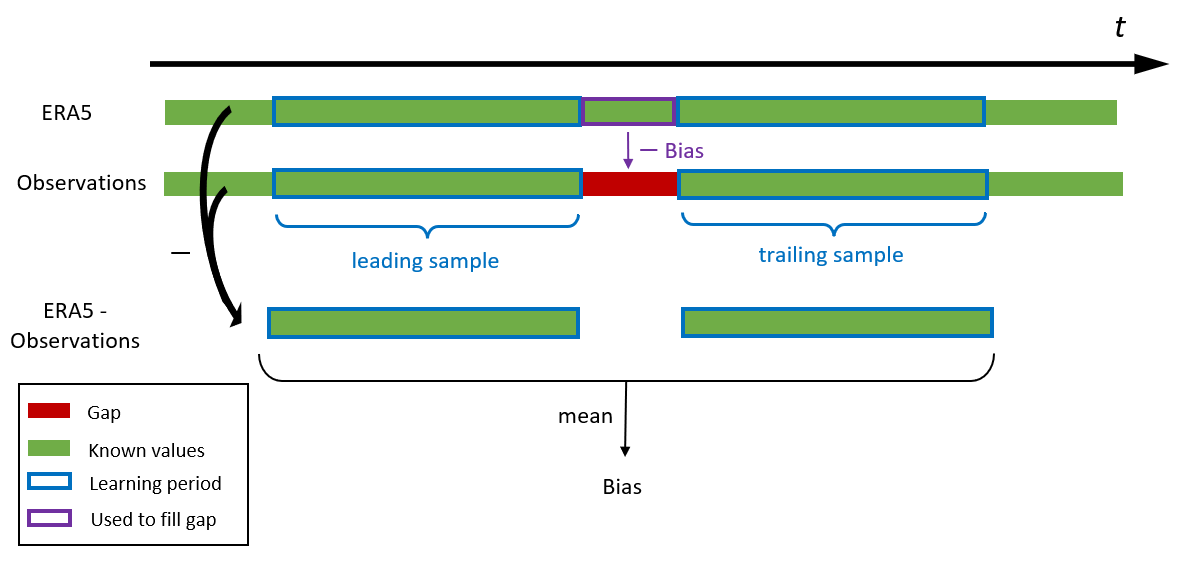

## E.2 Changing the settings of the gap-filling techniques

The exact working mechanism of the different gap-filling techniques are determined by some parameters. Depending on the value of these parameters the gap-filling techniques work slightly different. For example:
1. The linear interpolation technique can be performed with different 'methods', in which you can specify if the values of your data set are treated equally spaced in time or if the timestamp of the values needs to be taken into account.
2. The debiasing ERA5 technique can be performed with different lengths of learning periods. One of the parameters of this techniques determines the number of datapoints in the leading sample and trailing sample.
3. The length of the gap to swith between techniques during the hybrid method is also defined by a parameter.

The values of the parameters of the gap-filling techniques are stored in the settings. Run the code cel below to show the part of the current settings with information about the gap-filling functions. Try understand the meaning of the parameters.


For the listed examples above (example 1-3, one for each gap-filling technique), answer the following questions:
- Which parameter in the settings corespond to this example?
- What value is set for this parameter?


In [ ]:
# Show the current settings
demo_incomplete.settings.gap["gaps_fill_settings"]

The parameter values can be changed in the settings, by using the function `update_gap_and_missing_fill_settings()`. Change the code cel below to set the length of the prefered leading sample to 72 hours. Run the code cel below, which will change the settings and show the new settings and check if you were succesfull.

*Hint*: if you are stuck, consult the documentation on this function:

https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset_settings_updater.Dataset.html#metobs_toolkit.dataset_settings_updater.Dataset.update_gap_and_missing_fill_settings


In [ ]:
# Change the gap-filling settings:
demo_incomplete.update_gap_and_missing_fill_settings(CHANGE THIS)
demo_incomplete.settings.gap["gaps_fill_settings"]

Now you have an idea on the different parameters and how you can manipulate them. To be able to perform the gap-filling technique(s) with your desired settings, make sure you perform the following steps in this order:
1. Change the settings with `update_gap_and_missing_fill_settings()`.
2. If you want to check if the settings are correct: look at the settings.
3. Perform the gap-filling technique(s), and the updated settings will automatically be used.

If you still have some time left, you can experiment with this. Change some settings and redo the gap-filling of your data set. Do you see a large difference in the results?

In [ ]:
# If some time left, fill in the code to perform next steps.
# Change the settings

# PLACE CODE

# Look at the settings

# PLACE CODE

# Peform gap-filling

# PLACE CODE

# Look at the result of the gap-filling

# PLACE CODE